# A simple Transfer learning project

In this project, we demonstrate the principle of transfert learning; The repurposing of existing neural networks for new projects.

Deep neural networks can be expensive and time-consuming to train, with costs ranging from millions of dollars to processing times that can span months. However, the primary challenge lies in accessing the necessary data. Large companies, such as Google, often train their neural networks using proprietary data, which is closely guarded and constitutes the cornerstone of their flagship products, like Google's search engine.

With the advent of transfer learning, willing corporations such as Google can share fully trained models without compromising their data. Existing networks can therefore be downloaded by the little guys and be cut, twisted and modified at will, saving tons of time and money!

In this project, we will download EfficientNet B7, a convolutional network which, at the time, was known for its outstanding performance on computer vision tasks. The EfficientNet we donwload today was trained on datasets with thousands of labels, ranging from cats and dogs to cars and buildings.

We will repurpose this instance of EfficientNet to work as a vehicle classification module.

## The core principle
The classical transfer learning method and the one we will use is to cut the classification tail of a network and replace it with another model.

![Replacing the classification tail A with a neural network B.](./image/vgg-transfer-learning.png)

The new appendage only needs a few seconds to a few hours of training to be operational. In this project, we will compare the use of different models as the appendage.

**Terminology alert!**
After removing the tail of our neural network, we call the last layer the "feature map" (see the above image). It is a bunch of raw neurons, each representing a high-level *feature*, or a concept. For instance, a given neuron's activation can represent the presence of fur-like texture in the image, which in addition with other neurons would indicate the presence of a cat in the picture.

Now that we are done with the theory, **let's get started!**

## Get the data
For all intents and purposes, all you need to know is that we separate our data into training, testing, and validation datasets, with `X` as the input (raw image: red, green, blue), and `y` as the label ('bike', 'car', 'truck', ...). *You may skip the rest of this section.*

For curious readers, we retrieve our data from a folder structured as such: <br> ![File structure for the project](./image/file-structure.png)

The data is already segregated into train, test, and validation sets, with each set containing a folder for each class. It is an unusual way to store the data. To retrieve our images from those folders we use...
- `os.path.join(*args)` to create a platform-agnostic filepath (Linux and Windows): <br> ![Join folder names into a full path](./image/mypath.png)

- `os.path.split(string)` to get the label, contained as the parent folder name of our images: <br> ![Split path name to keep the label](./image/split-image.png)

- `glob` to search for all possible files, using the `*` wildcard: <br> ![Finding all files in data\train\bike](./image/wildcard-glob.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import split, join
from PIL import Image
from glob import glob

In [2]:
def get_data(paths):
    images = [np.array(Image.open(path)) for path in paths]
    labels = [split(split(path)[0])[1] for path in paths]
    return np.array(images), np.array(labels)

In [3]:
X_train, y_train = get_data(glob(join('data', 'train', '*', '*')))
X_test, y_test =   get_data(glob(join('data', 'test', '*', '*'))) 
X_valid, y_valid = get_data(glob(join('data', 'valid', '*', '*'))) 

In [4]:
print('     	 X                               y' )
print('train:\t', X_train.shape, X_train.dtype, '\t', y_train.shape, y_train.dtype )
print('test:\t',  X_test.shape, X_test.dtype,   '\t', y_test.shape, y_test.dtype)
print('valid:\t', X_valid.shape, X_valid.dtype, '\t', y_valid.shape, y_valid.dtype)

     	 X                               y
train:	 (280, 256, 256, 3) uint8 	 (280,) <U10
test:	 (50, 256, 256, 3) uint8 	 (50,) <U10
valid:	 (139, 256, 256, 3) uint8 	 (139,) <U10


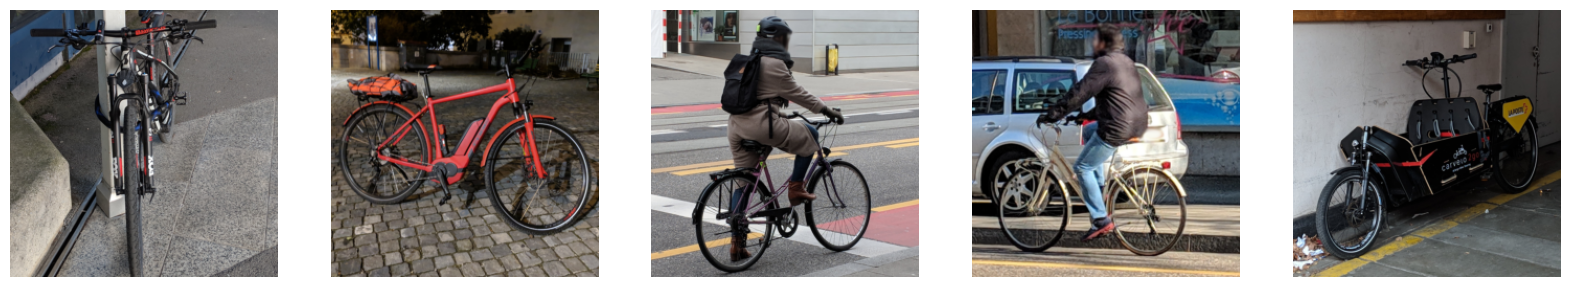

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(20,20))
[(axes[i].imshow(img), axes[i].axis('off'), ) for i, img in enumerate(X_train[0:5])]
plt.show()

## Preprocess the data
We prepare the data for training.
- The data is ordered, starting with bikes, cars, motorcycles ... We will shuffle the data to obtain a homogeneous training set, so the model doesn't suffer from **order bias**.
- Images are stored as RGB, with each color having a value within [0;255]. Neural Networks work better with normalized data [0;1].
- Labels are textual, however, neural networks work with floating-point numbers. We will encode labels: 'bike -> 0'
- All values fed to the neural network must be floating points. Labels can formatted as integers, but the output of the network will be as floating points, so let keep it as such.



In [6]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

In [7]:
# Shuffle.
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)
X_valid, y_valid = shuffle(X_valid, y_valid, random_state=0)

In [8]:
# Normalize.
X_train, X_test, X_valid = [(x)/255. for x in [X_train, X_test, X_valid]]
[(x.mean(), x.std(), x.min(), x.max()) for x in [X_train, X_test, X_valid]]

[(0.35457985159395966, 0.2352760946900631, 0.0, 1.0),
 (0.33193211255042376, 0.23457991338072745, 0.0, 1.0),
 (0.3512715323203296, 0.23815648599462888, 0.0, 1.0)]

In [9]:
# Encode labels.
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_valid = encoder.transform(y_valid)
dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

In [10]:
BIKE, CAR, MOTO, OTHER, TRUCK, VAN = 0, 1, 2, 3, 4, 5

In [11]:
# Format to float.
X_train, X_test, X_valid = [x.astype('float32') for x in [X_train, X_test, X_valid]]
y_train, y_test, y_valid = [y.astype('float32') for y in [y_train, y_test, y_valid]]
X_train.dtype, y_train.dtype

(dtype('float32'), dtype('float32'))

## Download and load [_EfficientNet_ B7](https://paperswithcode.com/paper/fixing-the-train-test-resolution-discrepancy-2)
At the time of working on this project, in 2020/04/28, [_EfficientNet_ B7](https://paperswithcode.com/paper/fixing-the-train-test-resolution-discrepancy-2) was two days old. It had one order of magnitude less parameters than the previous record holder (66M vs 556M parameters).

Note: On windows machines, we advise working with a later version of tensorflow (2.10.0) to have GPUs enabled.

In this chapter, we download Efficient Net B7 from the tensorflow hub, a reposit where many people shared their fully trained models for you to use! The hub offers to download our chosen model in a format ready for transfer learning: It's classification tail has already been removed! 

It wouldn't be too hard to remove said tail ourselves, but let's not bother with the busy work when lazy options are available. ;-)

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns

In [13]:
# Download module
module_url = 'https://tfhub.dev/google/efficientnet/b7/feature-vector/1'
feature_extractor = hub.KerasLayer(module_url)

# Create input placeholder.
input_imgs = tf.keras.Input(dtype=tf.float32, shape=[256, 256, 3])

# A node with the features.
imgs_features = feature_extractor(input_imgs)

# Create a TensorFlow model,.
model = tf.keras.Model(inputs=input_imgs, outputs=imgs_features)

## Extract a feature map for each image
We will use EfficientNet to generate a feature map for each image. The feature map will be a signature of sorts for each sample. Each type of vehicle should have a different yet typical signature.

In [14]:
# Extract features from EfficientNet-7.
print('X_train features...')
X_train_feat = model.predict(X_train)
print('X_test features...')
X_test_feat = model.predict(X_test)
print('X_valid features...')
X_valid_feat = model.predict(X_valid)
print('Done!')

X_train features...
9/9 [==============================] - 42s 5s/step
X_test features...
2/2 [==============================] - 7s 3s/step
X_valid features...
5/5 [==============================] - 18s 3s/step
Done!


In [15]:
# Notice the feature map has 2560 independent neurons, each representing an abstract concept.
print('     	 X                       y' )
print('train:\t', X_train_feat.shape, X_train_feat.dtype, '\t', y_train.shape, y_train.dtype )
print('test:\t',  X_test_feat.shape, X_test_feat.dtype,   '\t', y_test.shape, y_test.dtype)
print('valid:\t', X_valid_feat.shape, X_valid_feat.dtype, '\t', y_valid.shape, y_valid.dtype)

     	 X                       y
train:	 (280, 2560) float32 	 (280,) float32
test:	 (50, 2560) float32 	 (50,) float32
valid:	 (139, 2560) float32 	 (139,) float32


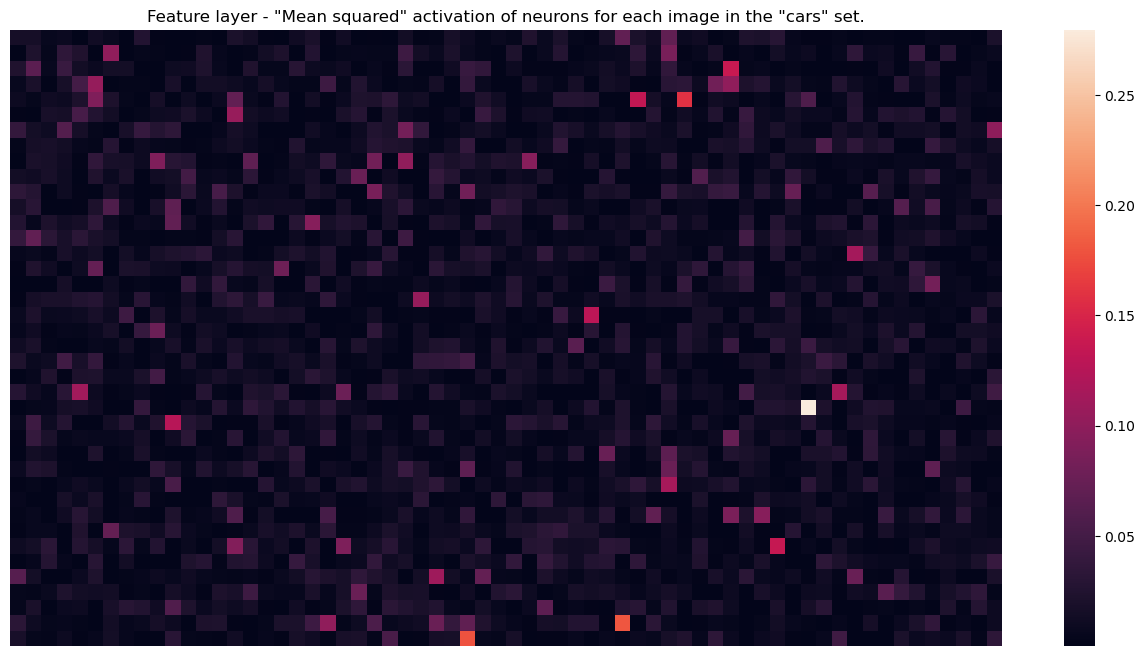

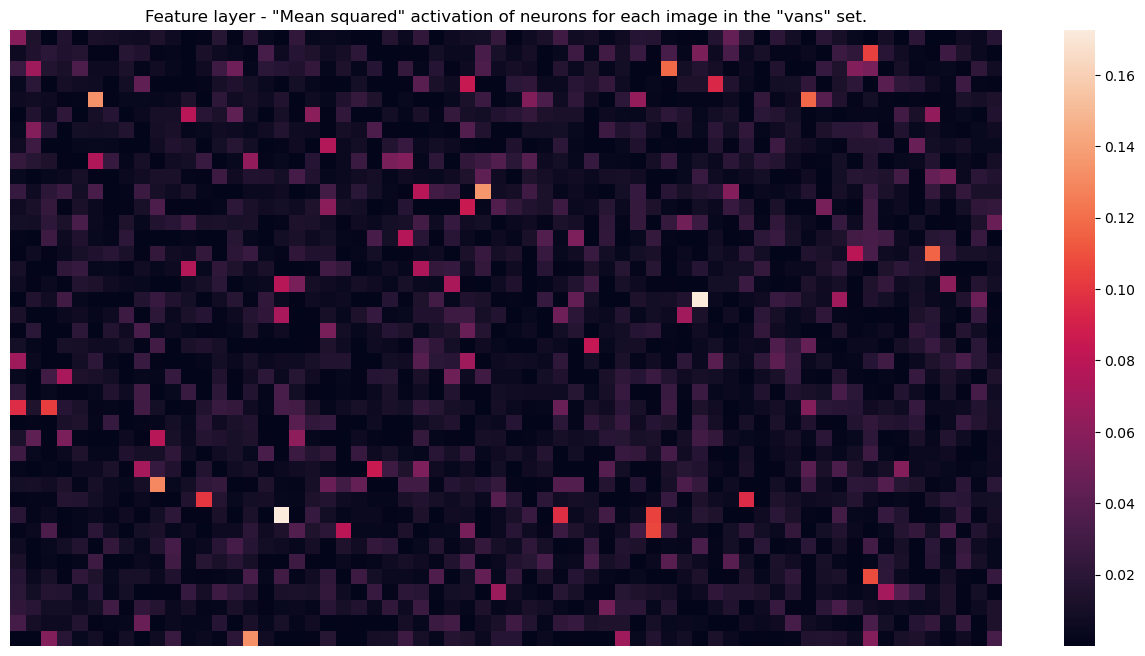

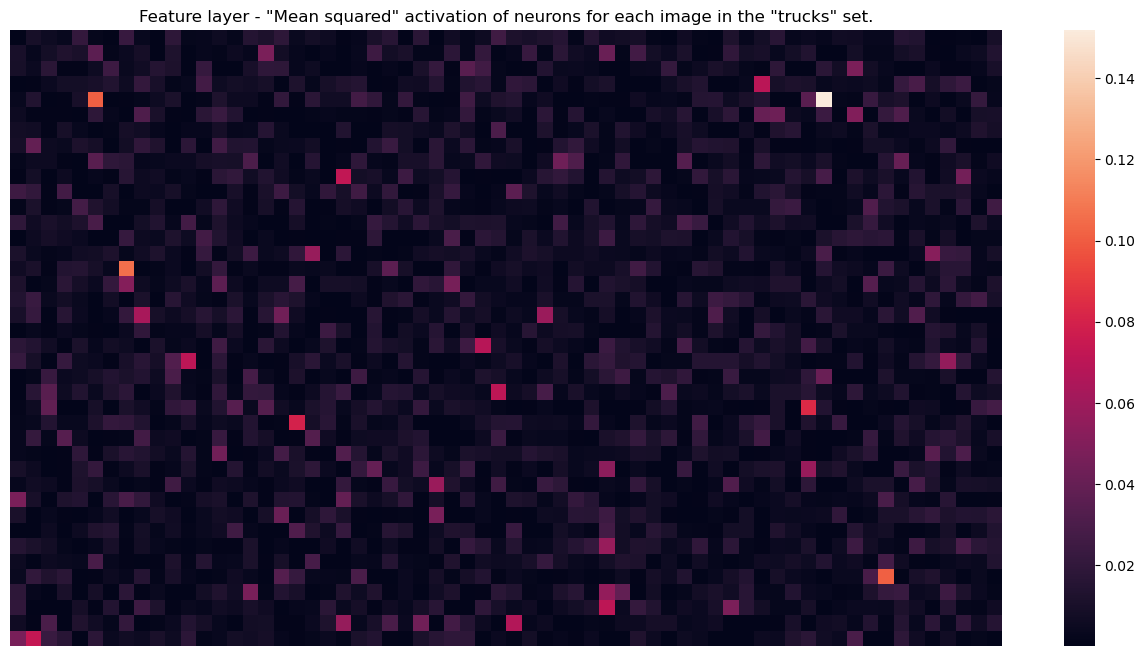

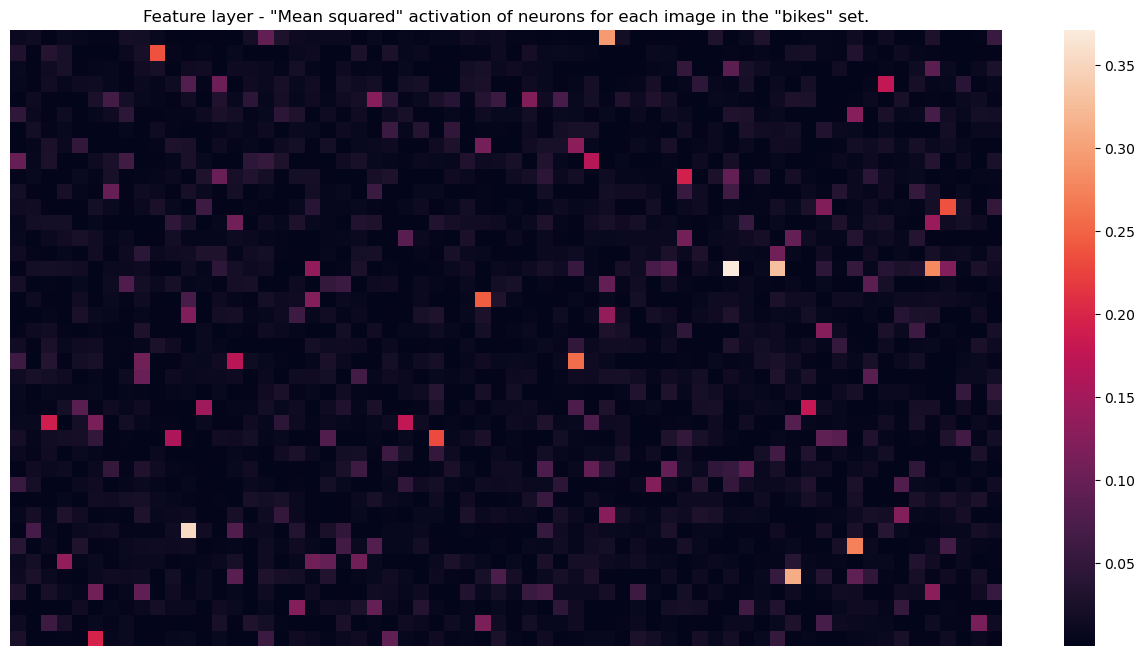

In [16]:
def show_feature_map(data, set_name):
    plt.figure(figsize=(16,8))
    ax = sns.heatmap(data.mean(axis=0).reshape(40, 64)**2, xticklabels=False, yticklabels=False)
    plt.title(f'Feature layer - "Mean squared" activation of neurons for each image in the "{set_name}" set.')
    plt.show()

# Cars only.
show_feature_map(X_train_feat[y_train == CAR], 'cars')

# Vans only.
show_feature_map(X_train_feat[y_train == VAN], 'vans')

# Trucks only.
show_feature_map(X_train_feat[y_train == TRUCK], 'trucks')

# Bikes only.
show_feature_map(X_train_feat[y_train == BIKE], 'bikes')

## Data Exploration
As we can see, bikes clearly distinguish themselves from other classes of vehicle. But how is it between each classes? Will our models be capable of distinguishing between a car and a van?

Additionnaly, many neurons serve absolutely not purpose as they are always deactivated. We will use a PCA to select only the small portion of the information that is useful (a.k.a. which explains variance), drastically reducing the ammount of data needed to train our mini-models, thus making training and predictions that much faster! >:D

But before that, we will make sure there are no biases or data imbalances that we need to be aware of:
- Manually review samples of each classes. It is the most important, yet often forgotten step.
- Check for class imblanaces. If there are 99% cars, the model could have a 99% accuracy simply by predicting car everytime! This wouldn't be a useful model.
- Then as discussed above, we will select the most valuable features (axes of features to be precise) using a PCA
- Finally, we will visually evaluate how different each classes are from one another and see if the number of components we selected for our PCA will lead to good results (If we can distinguish classes). Because a visually readable graph has only two axis, (x,y), we will need to compress the PCA of n features down to 2 for cluster analysis. This is where t-SNE will come in handy, mapping close together samples that are alike, while separating those which are different.

In [17]:
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

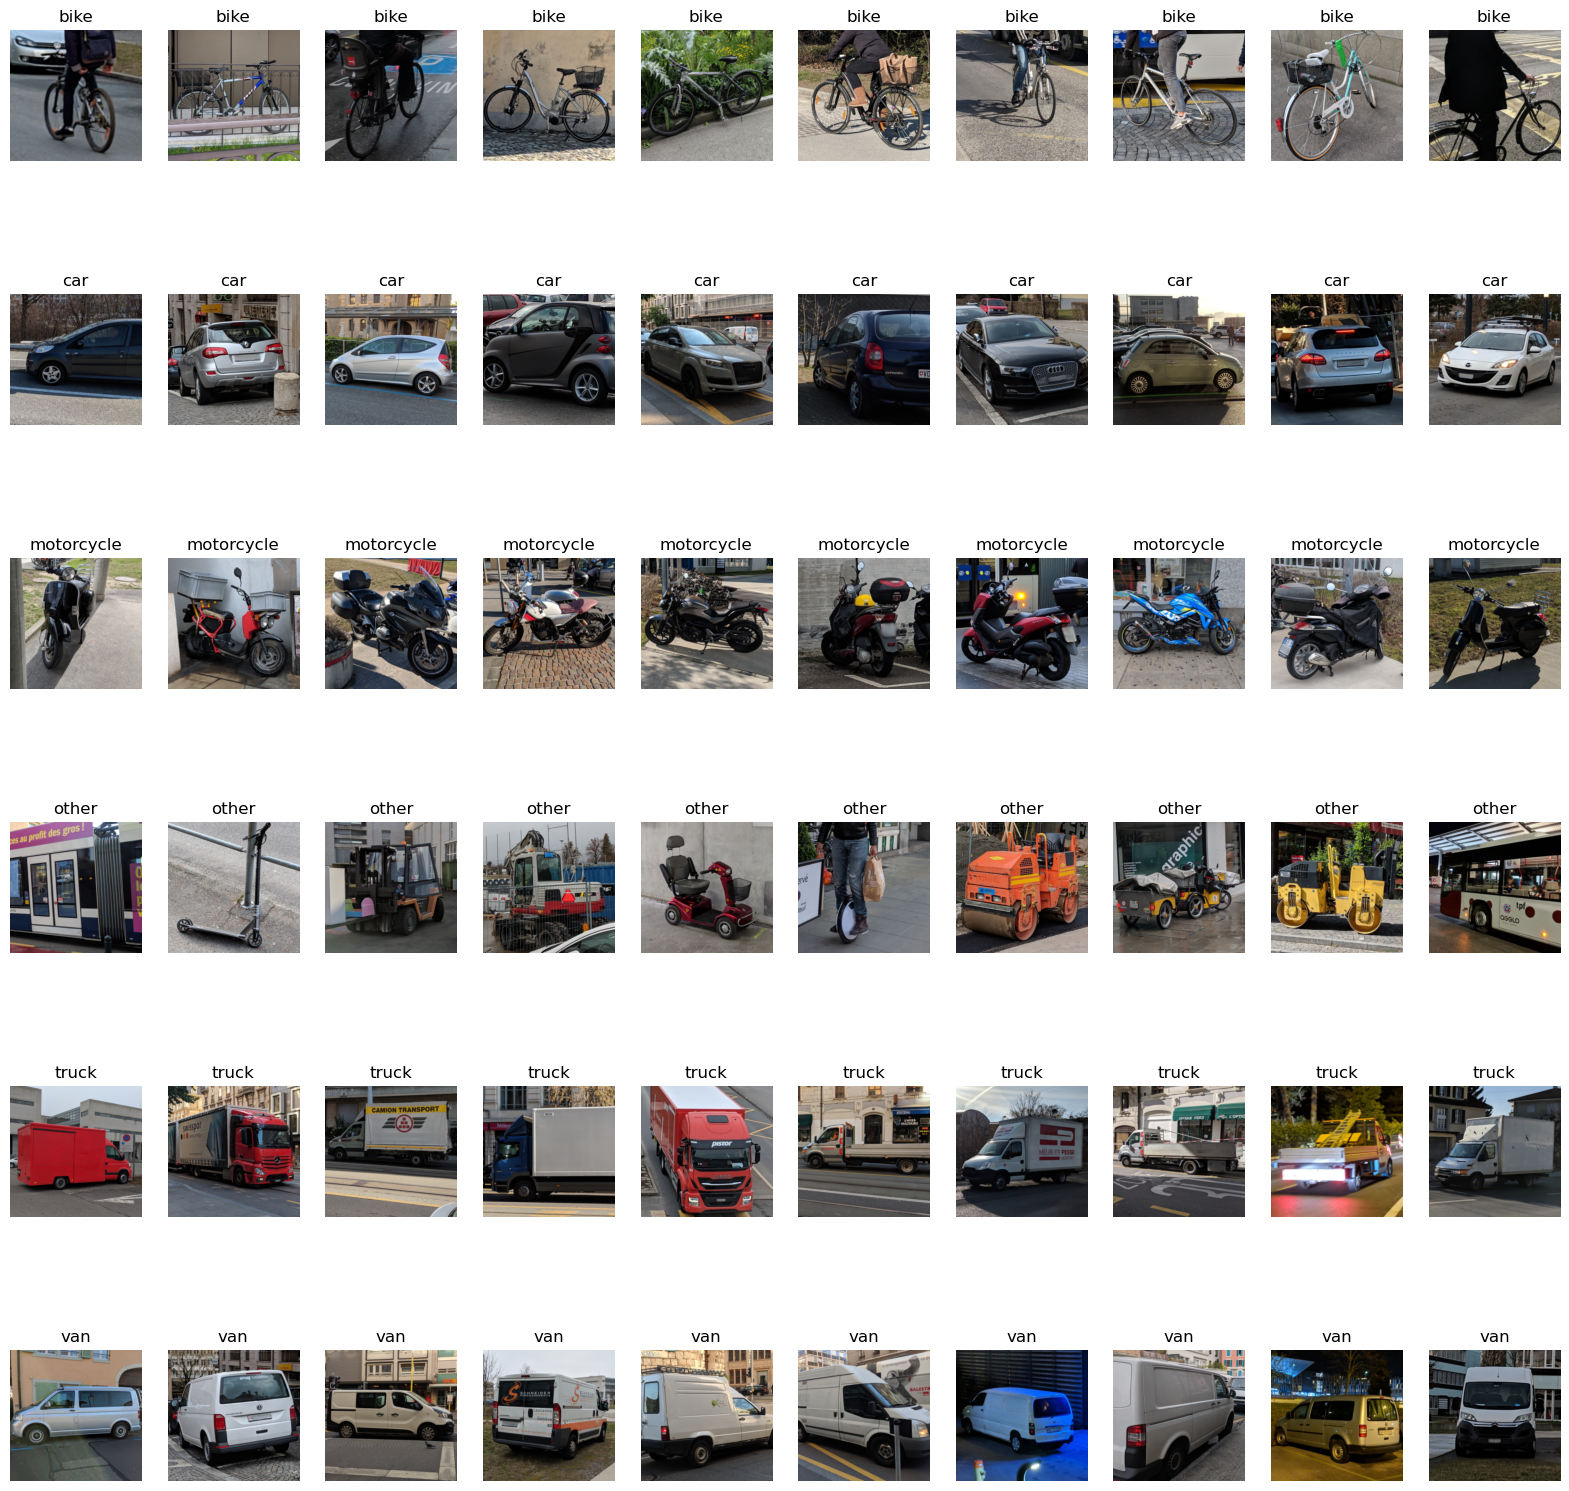

In [18]:
# Manual sample review.
    # Notice the extreme variety found in the "other" class.
labels = pd.DataFrame({'label':y_train})
indexes = labels.groupby('label').head(10).sort_values('label').index
fig, ax = plt.subplots(6, 10, figsize=(20,20))
axes = ax.flatten()
class_dict = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
for i, axe in enumerate(axes):
    index = indexes[i]
    axe.imshow(X_train[index])
    axe.axis('off')
    axe.set_title(class_dict[y_train[index]])
    
plt.show()

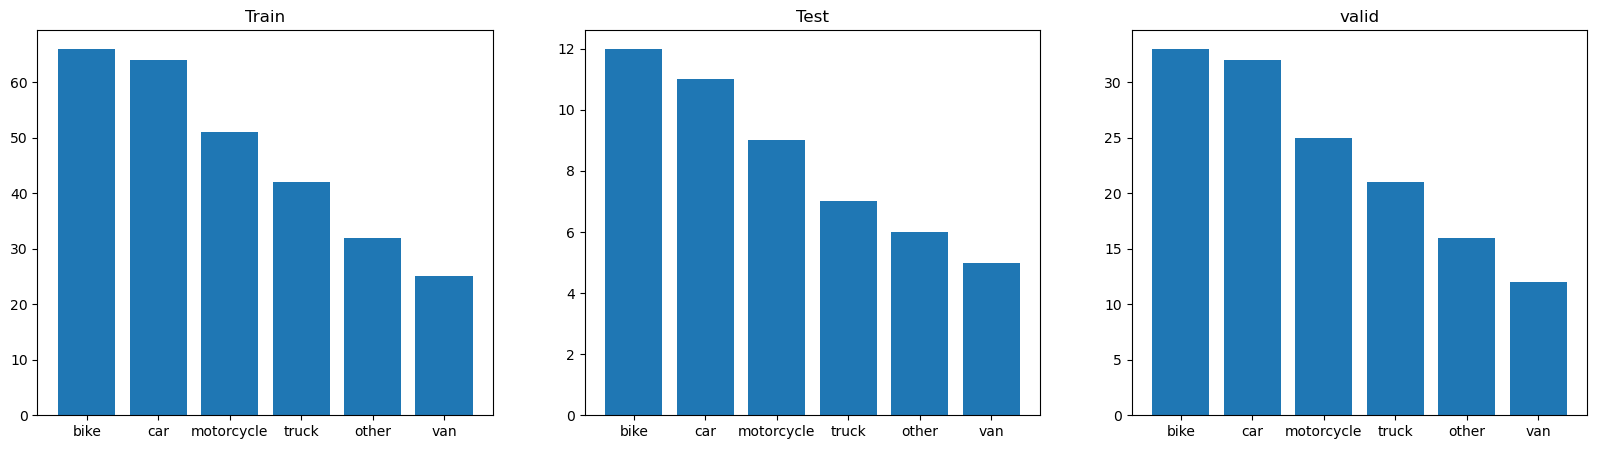

In [19]:
# Check for class imbalance.
    # There is some imbalance, but nothing major. All classes have a similar representation in each dataset.
to_bar = Counter(class_dict[y] for y in y_train).most_common()
to_bar2 = Counter(class_dict[y] for y in y_test).most_common()
to_bar3 = Counter(class_dict[y] for y in y_valid).most_common()

fig, axes = plt.subplots(1, 3, figsize=(20,5))

name, count = list(zip(*to_bar))
axes[0].bar(name, count)
axes[0].set_title('Train')

name, count = list(zip(*to_bar2))
axes[1].bar(name, count)
axes[1].set_title('Test')

name, count = list(zip(*to_bar3))
axes[2].bar(name, count)
axes[2].set_title('valid')

plt.show()

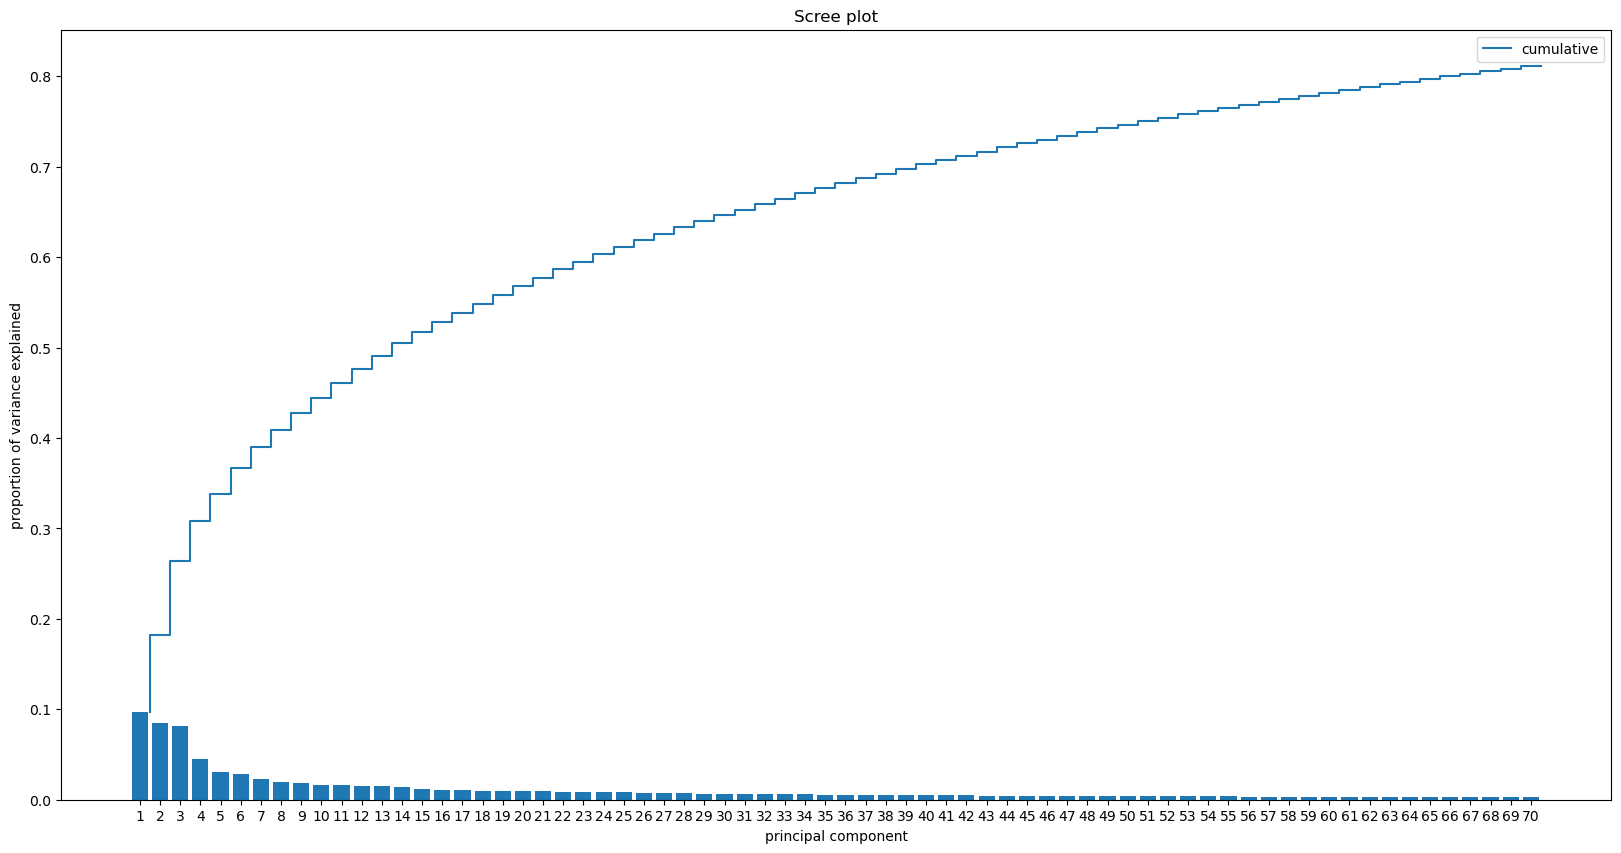

In [20]:
# To select a good number of components to keep when using a PCA, we'll use a scree plot!
scaler = StandardScaler()
pca = PCA()
X_train_rescaled = scaler.fit_transform(X_train_feat)
X_train_pca = pca.fit_transform(X_train_rescaled, y=None)

# We analyze the 70 most influential components; including more would make the scree plot overwhelming.
pve = pca.explained_variance_ratio_[0:70]


plt.figure(figsize=(20,10))
xcor = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum.
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels.
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.legend()
plt.title('Scree plot')
plt.show()

* 10% of the information is explained by 1 component
* 20% of the information is explained by 2 components
* 50% of the information is explained by 14 components
* 80% of the information is explained by 70 components

About 5 to 10 components should be the ideal number to provide a good prediction. When training our models, we will use hyper-parameter tuning to find the ideal number of component for each model.

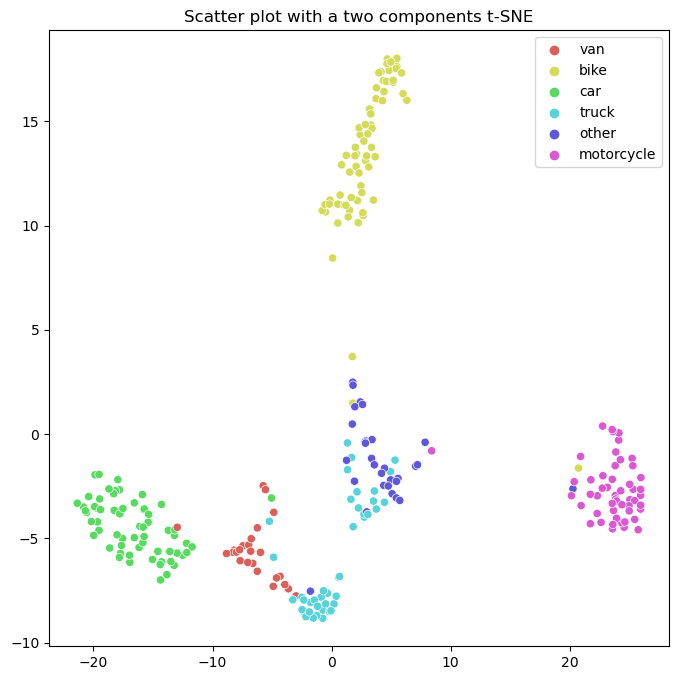

In [21]:
# Then we use PCA and t-SNE with a scatterplot to see if classes are distinct (easy to classify) or mixed (hard to classify).
pca = PCA(n_components=6) # 6 components is the sweet spot. More obfruscates instead of helping.
tsne = TSNE(n_components=2) # t-SNE compresses 6 components to 2 variables, so what we can display the data in a 2d scatter plot.
X_train_pca = pca.fit_transform(X_train_rescaled, y=None)
X_train_tsne = tsne.fit_transform(X_train_pca)
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=X_train_tsne[:,0], y=X_train_tsne[:,1], hue=[class_dict[y] for y in y_train], palette=sns.color_palette("hls"))
_ = ax.set_title('Scatter plot with a two components t-SNE')

Cars, bikes, and motorcycles exhibit distinct feature maps when compared with other classes. In contrast, the "other" class can often be confused with the "truck" class. Manual sample reviews and t-SNE clearly demonstrate that there are two types of trucks: The box truck and the flatbed truck. The flatbed is easily confused with "other" while the box truck is very similar, yet distinct to the "van" category.

## Adding our own model
Since we've successfully loaded the EfficientNet B7 model and generated feature maps for each entry, our next goal is to develop our own models responsible for the final classification steps, utilizing the feature maps to classify each entry accordingly.

To do so, we will try five models:
- k-Nearest Neighbor
- Logistic Regression
- Random Forest
- A Support Vector Machine
- A two-layer dense neural network

For the sake of clarity, and since you're here to learn about transfer learning, we'll focus on showcasing the use of k-NN. We'll also present the results from the other four models, which were trained separately from this presentation.

- We will use hyper-parameter tuning to find the best parameters
- Train our model and visualize the validation curves

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
# Create a pipeline.
pipeline = Pipeline([
    ('pca', None),
    ('knn', KNeighborsClassifier(n_jobs=-1))])

# Setup the hyper-parameters we wish to tune.
params = [
    {
        'knn__n_neighbors': np.arange(1, 10),
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['brute'],
        'knn__p': [1, 2],
        'pca': [PCA()],
        'pca__n_components': np.arange(1, 14),
    },
    # To demonstrate the gains made by using PCA, we will showcase 
    # what happens when we use the raw feature map, full of noise
    # and useless values.
    {
        'knn__n_neighbors': np.arange(1, 10),
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['brute'],
        'knn__p': [1, 2],
        'pca': [None], # No PCA! 
    },
]

# The k-NN model takes seconds to train. Therefore, we can fully 
# search every combination of hyperparameters to our heart's content!
model = GridSearchCV(
    pipeline, 
    param_grid=params, 
    n_jobs=-1, 
    cv=10, 
    return_train_score=True)

In [24]:
# Let the training begin!
_ = model.fit(X=X_train_feat, y=y_train)

**The best hyper-parameters are:**
* knn__n_neighbors: 5 to 7
* knn__p: does not matter
* knn__weights: 'distance'
* pca: significantly improves results by 2-3%
* pca__n_components: 6 to 12

**RESULTS:**

In [39]:
print(f'''Best Score:
train accuracy: \t {model.score(X_train_feat, y_train) :.2}
valid. accuracy:\t {model.score(X_valid_feat, y_valid) :.2}
test accuracy:  \t {model.score(X_test_feat, y_test) :.2}''')
keys = ['knn__n_neighbors', 'knn__weights', 'knn__algorithm', 'knn__p', 'pca']
print('\nBest model\'s parameters:\n', [(key, model.best_estimator_.get_params()[key]) for key in keys], '\n')

print('The 10 best models are:')
gs_results = pd.DataFrame(model.cv_results_['params'])
gs_results['mean_test_score'] = model.cv_results_['mean_test_score']
gs_results['mean_train_score'] = model.cv_results_['mean_train_score']
gs_results['std_test_score'] = model.cv_results_['std_test_score']
gs_results['std_train_score'] = model.cv_results_['std_train_score']
gs_results.sort_values('mean_test_score', ascending=False).head(10)

Best Score:
train accuracy: 	 1.0
valid. accuracy:	 0.94
test accuracy:  	 0.96

Best model's parameters:
 [('knn__n_neighbors', 7), ('knn__weights', 'distance'), ('knn__algorithm', 'brute'), ('knn__p', 1), ('pca', PCA(n_components=12))] 

The 10 best models are:


knn__algorithm  knn__n_neighbors  knn__p knn__weights  \
336          brute                 7       1     distance   
385          brute                 8       1     distance   
410          brute                 8       2     distance   
333          brute                 7       1     distance   
413          brute                 8       2     distance   
226          brute                 5       1     distance   
323          brute                 7       1      uniform   
412          brute                 8       2     distance   
411          brute                 8       2     distance   
320          brute                 7       1      uniform   

                      pca  pca__n_components  mean_test_score  \
336  PCA(n_components=12)               12.0         0.939286   
385  PCA(n_components=12)                9.0         0.935714   
410  PCA(n_components=12)                8.0         0.935714   
333  PCA(n_components=12)                9.0         0.935714   
413  PCA(n_components=12)               11.0         0.935714   
226  PCA(n_components=12)                6.0         0.935714   
323  PCA(n_components=12)               12.0         0.935714   
412  PCA(n_components=12)               10.0         0.935714   
411  PCA(n_components=12)                9.0         0.935714   
320  PCA(n_components=12)                9.0         0.935714   

     mean_train_score  std_test_score  std_train_score  
336          1.000000        0.045316         0.000000  
385          1.000000        0.052489         0.000000  
410          1.000000        0.050000         0.000000  
333          1.000000        0.052489         0.000000  
413          1.000000        0.052489         0.000000  
226          1.000000        0.044607         0.000000  
323          0.942063        0.047380         0.006687  
412          1.000000        0.050000         0.000000  
411          1.000000        0.050000         0.000000  
320          0.942460        0.052489         0.008918

In [26]:
def valid_curve(df, X_columns_name, xlabel):
    test, train = df['mean_test_score'], df['mean_train_score']
    std_test, std_train = df['std_test_score'], df['std_train_score']

    X = df[X_columns_name]

    plt.plot(X, test, label='valid.')
    plt.plot(X, train, label='train')

    plt.fill_between(X, test+std_test, test-std_test, alpha=0.2)
    plt.fill_between(X, train+std_train, train-std_train, alpha=0.2)

    plt.legend()
    plt.title('Validation curves')
    plt.ylabel('Accuracy')
    plt.xlabel(xlabel)
    plt.show()


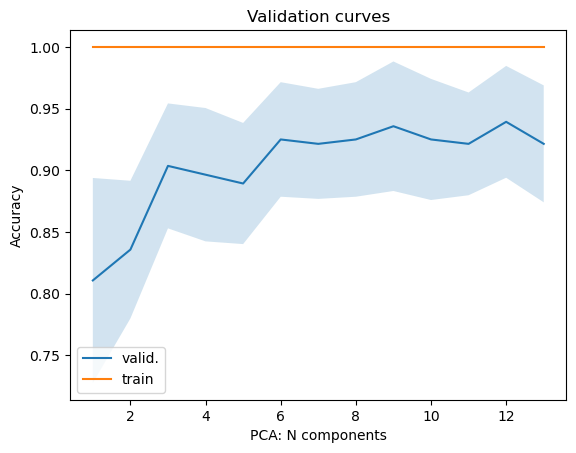

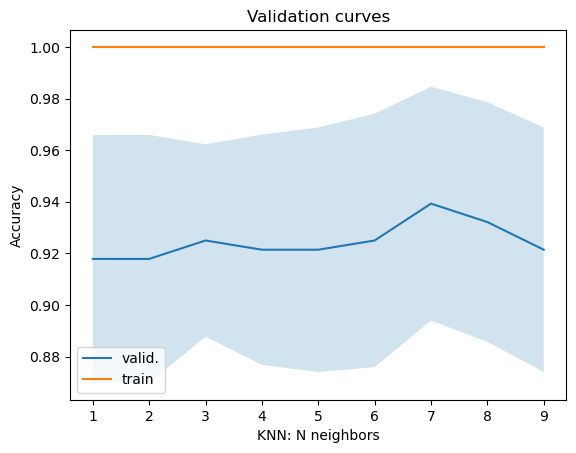

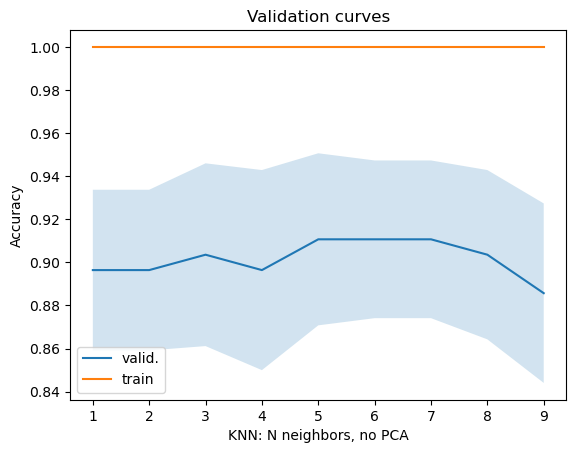

In [27]:
use_pca = gs_results.pca.notna()
use_distance = gs_results['knn__weights'] == 'distance'
p_is_1 = gs_results['knn__p'] == 1
has_7_neighbors = gs_results['knn__n_neighbors'] == 7
has_12_comp = gs_results['pca__n_components'] == 12

# How many N components provide the best result?
data = gs_results[use_distance & p_is_1 & use_pca & has_7_neighbors]
valid_curve(data, 'pca__n_components', 'PCA: N components')

# How many clusters do we need to properly classify the data?
data = gs_results[use_distance & p_is_1 & use_pca & has_12_comp]
valid_curve(data, 'knn__n_neighbors', 'KNN: N neighbors')

# What happens when we don't use PCA?
data = gs_results[use_distance & p_is_1 & ~use_pca]
valid_curve(data, 'knn__n_neighbors', 'KNN: N neighbors, no PCA')

## BONUS: Using k-NN to create a [Sharp Eyes Project (雪亮工程)](https://en.wikipedia.org/wiki/Mass_surveillance_in_China) at home

Because the feature map created by EfficientNet B7 effectively serves as a pseudo-signature, we can use k-NN to find which images within our database are the closest to a given reference. In this bonus example, we will create a simple program that takes as input a reference (the car whose identity you want to know!) and outputs a list of the 9 closest matches in our database. Enjoy the dystopian future, [Yippee!](https://www.youtube.com/watch?v=0CqEKoy-fIQ)

Whith the following drop-down box you can selecte items within the trainning set. It will then search for the closest matches. Not that only items with a <= 0.5 certainty will be considered as a match. a distance of 1.0 is quit large already, so keep in minde the AI only has 300 entries from which to match, it many not have a lot of duplicates.

In [28]:
from ipywidgets import interact

In [37]:
# Merge datasets.
feature_maps = np.concatenate([X_train_feat, X_test_feat, X_valid_feat])
images = np.concatenate([X_train, X_test, X_valid])
labels = np.concatenate([y_train, y_test, y_valid])

# Create a new model using every images and the best hyper-parameters.
full_model = pipeline = Pipeline([
    ('pca', PCA(n_components=8)),
    ('knn', KNeighborsClassifier(n_jobs=-1, n_neighbors=6, weights='distance', algorithm='brute', p=1))])

full_model.fit(X=feature_maps, y=labels)

@interact
def show_neighbors(idx=np.arange(0, len(images))):
    reference_feature_map = feature_maps[np.newaxis, idx]
    reference_image= images[idx]
    reference_label = labels[idx]
    
    knn = full_model['knn']  
    pca = full_model['pca']  
    distances, indexes = knn.kneighbors(pca.transform(reference_feature_map), 9)

    selected_images = images[indexes]
    selected_images = selected_images.reshape(9, 256, 256, 3)
    distances = distances.reshape(9)
    
    fig, ax = plt.subplots(2, 5, figsize=(15,6))
    for i, axe in enumerate(ax.flatten()):
        if i==0:
            axe.imshow(reference_image)
            axe.axis('off')
            axe.set_title('Reference ' + class_dict[reference_label])
        else:
            axe.imshow(selected_images[i-1])
            axe.axis('off')
            certainty = round(distances[i-1], 2)
            if certainty <= 0.5:
                axe.set_title(f'Match Found! {certainty}')  
            else:
                axe.set_title(certainty)

    plt.show()
    print('Indices of the nine closest images:', indexes)

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

For thoes watching from the GitHub viewer, without access to the interactive library, here is what our bootleg Sharp Eyes Project looks like:

_____

![Green bike being matched at 1.15 certainty](./image/example-3.png)

_____

![Trucks being trucks](./image/exemple-2.png)

_____

![A postal bike being matched with a 3.53 certainty](./image/example-1.png)

## Results
- The k-NN model yielded an accuracy of 96% with only a few seconds of training. This makes k-NN a quick and high-quality baseline for classification projects.
- The Support Vector Machine (SVM), our best-performing model, achieved an impressive 98% accuracy. However, its training time increases exponentially with the size of the dataset. This could be a limiting factor for larger projects, so careful consideration of computational resources is essential.
- Random forests and neural networks stand out as some of the most versatile models, both archieving accuracies of 97% and having more scalable training times compared to SVMs.
- A single tree lacks the capacity to grasp the intricacies of our problem beyond an accuracy of 92%. Nonetheless, employing ensemble models like XGBoosted trees could have resulted in a quick-to-train and high-quality model.
- Despite their names, logistic regressions are commonly used for classification tasks rather than regression. Naming conventions be damned!

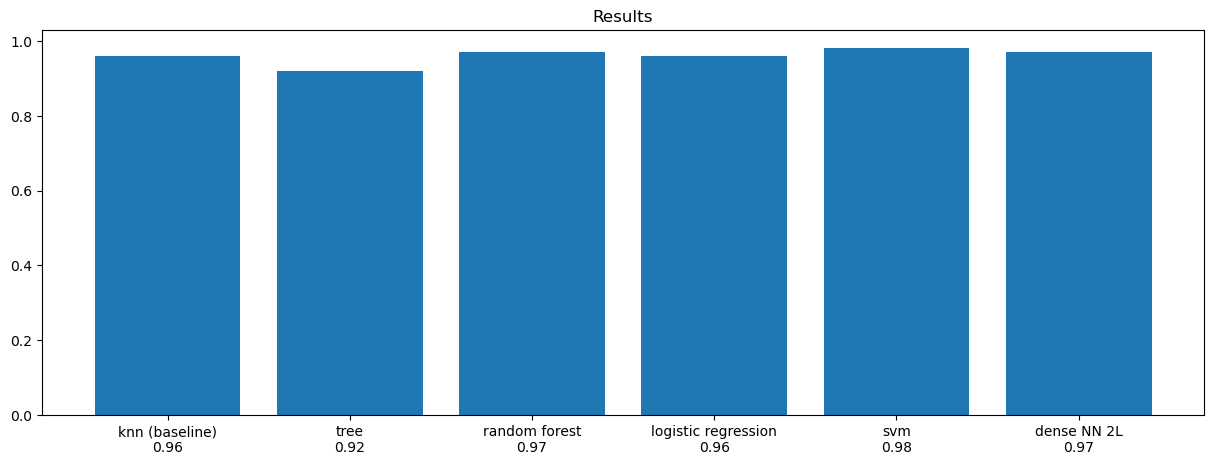

In [30]:
results={'knn (baseline)': 0.96, 'tree': 0.92, 'random forest': 0.97, 'logistic regression': 0.96, 'svm': 0.98, 'dense NN 2L': 0.97}
plt.figure(figsize=(15,5))
x = [f'{item[0]}\n{item[1]}' for item in results.items()]
plt.bar(x, results.values())
plt.title('Results')
plt.show()